# defines the environment variable to prepare the data, train the ML model, and deploy the ML model.

### Import the required libraries 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from time import gmtime, strftime

import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Define IAM role

In [2]:
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
# set the region of the instance
my_region = boto3.session.Session().region_name 

### Define the ML algorithm XGBoost

In [3]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

In [4]:
print("The SageMaker Instance region is: " + my_region + " .\nAnd will use the " + xgboost_container + " container for your SageMaker endpoint.")

The SageMaker Instance region is: us-west-2 .
And will use the 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [8]:
bucket_name = 'alaa-sedeeq'

s3 = boto3.resource('s3')

try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region })
    print('S3 bucket created successfully')
    
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


### Download the data to my SageMaker instance and load the data into a dataframe. 

In [9]:
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv', index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


### Shuffle and split the data into training data and test data. 
- The training data (70% of customers) is used during the model training loop.
- The test data (remaining 30% of customers) is used to evaluate the performance of the model and measure how well the trained model generalizes to unseen data.

In [10]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=0), [int(0.7 * len(model_data))])

print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


## Train the ML model

In [11]:
# reformats the header and first column of the training data and then loads the data from the S3 bucket. 
# This step is required to use the Amazon SageMaker pre-built XGBoost algorithm.
pd.concat(
    [
        train_data['y_yes'], 
        train_data.drop(['y_no', 'y_yes'], axis=1)
    ], 
    axis=1).to_csv('train.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [12]:
# Set up the Amazon SageMaker session, create an instance of the XGBoost model (an estimator)
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(
    xgboost_container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
    sagemaker_session=sess
)
# Define the model’s hyperparameters
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective='binary:logistic',
    num_round=100
)

In [13]:
# trains the model using gradient optimization
xgb.fit({'train': s3_input_train})

2022-08-24 11:26:16 Starting - Starting the training job...ProfilerReport-1661340376: InProgress
...
2022-08-24 11:27:00 Starting - Preparing the instances for training......
2022-08-24 11:28:00 Downloading - Downloading input data......
2022-08-24 11:29:01 Training - Downloading the training image...
2022-08-24 11:29:45 Training - Training image download completed. Training in progress..Arguments: train
[2022-08-24:11:29:49:INFO] Running standalone xgboost training.
[2022-08-24:11:29:49:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-08-24:11:29:49:INFO] File size need to be processed in the node: 3.38mb. Available memory size in the node: 8824.04mb
[2022-08-24:11:29:49:INFO] Determined delimiter of CSV input is ','
[11:29:49] S3DistributionType set as FullyReplicated
[11:29:49] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[11:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes

## Deploy the model
- Deploy the model on a server and creates a SageMaker endpoint that you can access.

In [14]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

-------!

### Predict whether customers in the test data enrolled for the bank product or not

In [15]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


## Evaluate model performance

In [16]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
tp = cm.iloc[1,1]
fp = cm.iloc[0,1]
p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Observed
No Purchase    90% (10769)    37% (167)
Purchase        10% (1133)     63% (288) 



In [32]:
# convert predictions to binary values
y_true, preds = test_data.drop('y_yes', axis=1), np.where(predictions_array>0.5, 1, 0)
# get the confusion matrix
M = confusion_matrix(y_true, preds)

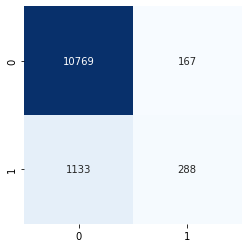

In [33]:
# plot the confusion matrix
sns.heatmap(M, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

## Clean up
- Terminate the resources used in this Notebook.
- Terminating resources that are not actively being used reduces costs and is a best practice. 
- Not terminating your resources will result in charges to your account.

In [34]:
# Delete endpoint
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

# Delete training artifacts and S3 bucket
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'ND5AJCR786JF7BTC',
   'HostId': 'iH5K1b31DaKEGoxKvybEEluWr2rTg4CpgMwJondHM/6cumfGD1y5h4/fWXfYOzcLNw7lc+foHiE=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'iH5K1b31DaKEGoxKvybEEluWr2rTg4CpgMwJondHM/6cumfGD1y5h4/fWXfYOzcLNw7lc+foHiE=',
    'x-amz-request-id': 'ND5AJCR786JF7BTC',
    'date': 'Wed, 24 Aug 2022 11:47:41 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-08-24-11-26-16-592/profiler-output/system/incremental/2022082411/1661340540.algo-1.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-08-24-11-26-16-592/rule-output/ProfilerReport-1661340376/profiler-output/profiler-reports/StepOutlier.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-08-24-11-26-16-592/rule-output/ProfilerReport-1661340376/profiler-output/profiler-re

## The last step is to delete SageMaker Notebook